In [1]:
!pip install pyyaml
!pip install dndice
!pip install python-i18n
!pip install gymnasium
!pip install inflect
!pip install collections-extended
!pip install openai
!pip install -e ..
!pip install ipywidgets
!pip install iprogress


Obtaining file:///home/jedld/workspace/natural_20.py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: natural20.py
    Found existing installation: natural20.py 0.1
    Uninstalling natural20.py-0.1:
      Successfully uninstalled natural20.py-0.1
  Running setup.py develop for natural20.py


In [2]:
from gymnasium import make
from model import QNetwork
from natural20.gym.dndenv import dndenv
import torch
import tqdm as tqdm
import tqdm.notebook as tqdm
import random
import torch.optim as optim
import torch.nn as nn
import gc
import numpy as np
import sys
import collections
from natural20.session import Session
from natural20.event_manager import EventManager

In [3]:
if torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [4]:
env_config = "map_with_obstacles"

In [5]:
session = Session(env_config, event_manager=EventManager())

Show info about the environment and a render of the tabletop map

In [6]:
env = make("dndenv-v0", root_path="map_with_obstacles", show_logs=True,
           custom_session=session,
           damaged_based_reward=True,
           render_mode="ansi")
env.reset()
print(env.render())
print(env.observation_space)
print(env.action_space.sample)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



____________
____________
____________
____________
____________
____________
___...P...__
___.......__
___...#...__
___E~~ ~..__
___~~~ ...__
___~~   ..__
Dict('ability_info': Box(0, 1, (8,), int64), 'conditions': Box(0, 1, (8,), int64), 'enemy_ac': Box(0.0, 255.0, (1,), float64), 'enemy_conditions': Box(0, 1, (8,), int64), 'enemy_reactions': Box(0, 1, (1,), int64), 'enemy_type': Box(0, 1, (1,), int64), 'health_enemy': Box(0.0, 1.0, (1,), float64), 'health_pct': Box(0.0, 1.0, (1,), float64), 'map': Box(-1, 255, (12, 12, 5), int64), 'movement': Discrete(255), 'player_ac': Box(0, 255, (1,), int64), 'player_equipped': Box(0, 255, (5,), int64), 'player_type': Box(0, 1, (1,)

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.ndarray'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/home/jedld/.local/lib/python3.10/site-packages/

DQN Parameters

In [7]:
TRAJECTORY_POLICY = "e-greedy"
NUM_UPDATES = 2
TEMP_DECAY = 0.999
BUFFER_CAPACITY = 3000
FRAMES_TO_STORE = 2
MAX_STEPS = 10000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 1
T_HORIZON = 1024
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY_FRAMES = 10**3
EVAL_STEPS = 25

In [8]:
model = QNetwork(device=device)
model.to(device)
state, info = env.reset()
moves = info["available_moves"]
model.eval()
print(model(state, moves[0]))

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



tensor([[0.1793]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
def act_with_policy(state, info, model, policy='e-greedy', temperature=5.0, epsilon=0.1):
    available_moves = info["available_moves"]
    with torch.no_grad():
        if policy == 'boltzmann':
            values = torch.stack([model(state, move).squeeze() for move in available_moves])
            if len(values) > 1:
                if temperature != 0:
                    values = values / temperature
                else:
                    raise ValueError("Temperature is zero, which can lead to division by zero.")

                # Stabilizing the exponential calculation
                values = values - torch.max(values)  # Subtract the max value for numerical stability
                values = torch.exp(values)
                sum_values = torch.sum(values)

                if sum_values > 0:
                    values = values / sum_values
                    chosen_index = torch.multinomial(values, 1).item()
                else:
                    print("Sum of exponentiated values is zero. Adjust the model or input.")
                    chosen_index = torch.randint(len(available_moves), (1,)).item()
            else:
                chosen_index = 0
        elif policy == 'e-greedy':
            if random.random() < epsilon:
                # place available moves in buckets according to their type
                # this is so that movements are not chosen more often than other types of moves
                move_types = collections.defaultdict(list)
                for orig_index, move in enumerate(available_moves):
                    move_types[move[0]].append(orig_index)
                chosen_move_type = random.choice(list(move_types.keys()))
                chosen_index = random.choice(move_types[chosen_move_type])
            else:
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        elif policy == 'greedy':
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    return available_moves[chosen_index]

def generate_trajectory(env, model, policy='e-greedy', temperature=5.0, epsilon=0.1, horizon=2048, quick_exit=False):
    state, info = env.reset()
    done = False
    truncated = False
    states = []
    actions = []
    rewards = []
    dones = []
    truncateds = []
    infos = []
    truncated = False
    for _ in range(horizon):
        # instead of sampling  (e.g. env.action_space.sample()) we can ask help from the enivronment to obtain valid moves
        # as there are sparse valid moves in the environment
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        next_state, reward, done, truncated, next_info = env.step(action)       
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        if done:
            break    
        if truncated:
            truncated = True
            break
        state = next_state
        info = next_info
        
    states.append(next_state)
    infos.append(next_info)
    actions.append((-1, (0,0), (0,0), 0, 0))
    return states, actions, rewards, dones, truncateds, infos

In [10]:
trajectory = generate_trajectory(env, model, epsilon=1.0)
print(trajectory)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
Result: False


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'numpy.ndarray'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int64, actual type: float64
  logger.warn(


==== end turn ===
gomerin 5/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 5/18 AC 16===
Result: False
==== end turn ===
gomerin 5/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 5/18 AC 16===
Result: False
==== end turn ===
gomerin 5/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 4/18 AC 16===
Result: False
==== end turn ===
gomerin 4/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 3/18 AC 16===
Result: False
==== end turn ===
gomerin 3/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 3/18 AC 16===
Result: False
==== end turn ===
gomerin 3/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gome

In [11]:
EPISODES = 10
total_rewards = 0
for i in tqdm.tqdm(range(EPISODES)):
    states, actions, rewards, dones, truncateds, infos = generate_trajectory(env, model, epsilon=1.0)
    total_rewards += sum(rewards)

avg_reward = total_rewards/EPISODES
print(f"Average reward: {avg_reward} Total Reward: {total_rewards}")

  0%|          | 0/10 [00:00<?, ?it/s]

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
==== end turn ===
gomerin 12/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
Result: tpk
loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
==== end turn ===
gomerin 12/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==

In [12]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buffer = collections.deque(maxlen=capacity)
        self.device = device

    def push(self, states, actions, rewards, infos, is_terminal):
        converted_states = []
        converted_actions = []
        for x in states:
            health_enemy, health_pct, condition, enemy_condition, enemy_reaction, map_input, movement, \
                    turn_info, ability_info, player_type, enemy_type, player_ac, enemy_ac, player_equipped = \
                    x['health_enemy'], x['health_pct'], x['conditions'], x['enemy_conditions'], \
                    x['enemy_reactions'], x['map'], x['movement'], \
                    x['turn_info'], x['ability_info'], x['player_type'], x['enemy_type'], \
                    x['player_ac'], x['enemy_ac'], x['player_equipped']
            state = {}
            state['map'] = torch.tensor(map_input, dtype=torch.int).to(device)
            state['conditions'] = torch.tensor(condition, dtype=torch.float32)
            state['enemy_conditions'] = torch.tensor(enemy_condition, dtype=torch.float32)
            state['health_enemy'] = torch.tensor(health_enemy, dtype=torch.float32)
            state['health_pct'] = torch.tensor(health_pct, dtype=torch.float32)
            state['enemy_reactions'] = torch.tensor(enemy_reaction, dtype=torch.float32)
            state['movement'] = torch.tensor(movement / 255.0, dtype=torch.float32)
            state['turn_info'] = torch.tensor(turn_info, dtype=torch.float32)
            state['ability_info'] = torch.tensor(ability_info, dtype=torch.float32)
            state['player_type'] = torch.tensor(player_type[0], dtype=torch.long)
            state['enemy_type'] = torch.tensor(enemy_type[0], dtype=torch.long)
            state['player_ac'] = torch.tensor(player_ac, dtype=torch.float32)
            state['enemy_ac'] = torch.tensor(enemy_ac, dtype=torch.float32)
            state['player_equipped'] = torch.tensor(player_equipped, dtype=torch.long).to(device).unsqueeze(1)
            converted_states.append(state)

        for a in actions:
            action1, action2, action3, action4, action5 = a
            converted_actions.append((torch.tensor(action1, dtype=torch.long),
                                        torch.tensor(action2, dtype=torch.float32),
                                        torch.tensor(action3, dtype=torch.float32),
                                        torch.tensor(action4, dtype=torch.long),
                                        torch.tensor(action5, dtype=torch.long)))

        self.buffer.append((converted_states, converted_actions, rewards, infos, is_terminal))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size)
        states, actions, rewards, infos, is_terminals = zip(*[self.buffer[idx] for idx in indices])
        return states, actions, rewards, infos, is_terminals

    def __len__(self):
        return len(self.buffer)
    
    def print_stats(self):
        print(f"Buffer size: {len(self.buffer)}")
        print(f"Memory usage: {self.memory_usage()} bytes")
    
    # memory usage of the buffer in bytes
    def memory_usage(self):
        total_size = 0
        for item in self.buffer:
            states, actions, rewards, infos, is_terminals = item
            for s in states:
                total_size += sys.getsizeof(s)
            total_size += sys.getsizeof(actions)
            total_size += sys.getsizeof(rewards)
            total_size += sys.getsizeof(infos)
            total_size += sys.getsizeof(is_terminals)

        return total_size

In [13]:
# generate a batch of trajectories and store them in the replay buffer
def generate_batch_trajectories(env, model, n_rollout, replay_buffer: ReplayBuffer, temperature=5.0, epsilon=0.1, horizon=30, policy='e-greedy'):
    # print(f"generating {n_rollout} rollouts")
    for _ in range(n_rollout):
        state, action, reward, done, truncated, info = generate_trajectory(env, model, temperature=temperature,
                                                                           epsilon=epsilon,
                                                                           horizon=horizon,policy=policy)
        replay_buffer.push(state, action, reward, info, done)

In [14]:
def train(env, gamma, learning_rate, max_steps=MAX_STEPS, use_td_target=True,
          trajectory_policy='e-greedy',
          label="dnd_egreedy",
          n_rollout=8,
          seed=1337):
  print(f"training with gamma {gamma} and learning rate {learning_rate}")
  env.seed(seed)

  replay_buffer = ReplayBuffer(BUFFER_CAPACITY, device)
  # load model checkpoint if available
  model = QNetwork(device).to(device)
  target_model = QNetwork(device).to(device)

  # intialize target network with the same weights as the model
  target_model.load_state_dict(model.state_dict())

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_avg = -10
  best_step = 0
  temperature = 5.0
  reward_per_episode = []
  epsilon = EPSILON_START

  for step in tqdm.tqdm(range(max_steps)):
    generate_batch_trajectories(env, model, n_rollout, replay_buffer, temperature=temperature,
                                epsilon=epsilon, policy=trajectory_policy, horizon=T_HORIZON)

    states, actions, rewards, infos, is_terminals = replay_buffer.sample(BATCH_SIZE)
    rewards_collected = 0
    for _ in range(NUM_UPDATES):
      rewards_collected = 0
      total_loss = 0.0
      
      for i in range(len(states)):
        s = states[i]
        a = actions[i]
        env_info = infos[i]
        r = torch.tensor(rewards[i]).to(device).unsqueeze(1)
        is_terminal = torch.tensor(is_terminals[i]).float().to(device).unsqueeze(1)
        
        if use_td_target:
          with torch.no_grad():
            s_next = s[1:]
            a_next = a[1:]
            q_targets = target_model.forward(s_next, a_next, pre_converted=True, pre_converted_action=True).detach()
        else: # Q-learning target == "slow"
          with torch.no_grad():
            s_next = s[1:]
            s_info = env_info[1:]
            q_targets = torch.zeros(len(s_next)).to(device)
            
            for index in range(len(s_info)):
              info = s_info[index]
              state = s_next[index]
              
              if len(state) == 0:
                q_targets[index] = 0
                continue
              
              total_available_moves = len(info["available_moves"])
              states_t = [state] * total_available_moves
              avail_actions = info["available_moves"]
              assert len(states_t) > 0, "No available states"
              assert len(avail_actions) > 0, "No available moves"
              
              q_values = target_model.forward(states_t, avail_actions, pre_converted=True).detach().squeeze(1)
              if len(q_values) == 0:
                q_targets[index] = 0
              else:
                q_targets[index] = torch.max(q_values).item()

            q_targets = q_targets.unsqueeze(1)
            assert q_targets.shape == r.shape, f"q_targets shape {q_targets.shape} != r shape {r.shape}"

        targets = r + gamma * q_targets * (1 - is_terminal)
        
        s_input = s[0:-1]
        a_input = a[0:-1]
        output = model.forward(s_input, a_input, pre_converted=True, pre_converted_action=True)
        q_sa = output

        value_loss = nn.MSELoss()(q_sa, targets)
        optimizer.zero_grad()
        value_loss.backward()
        total_loss += value_loss.item()
        rewards_collected += r.sum().item()
        optimizer.step()

    # save model checkpoint

    if step % 10 == 0:
      # torch.save(model.state_dict(), f"model_{step}.pt")
      eval_rewards = []
      for _ in range(EVAL_STEPS):
        _, _, rewards, _, _, _ = generate_trajectory(env, model, policy='greedy')
        total_reward = sum(rewards)
        eval_rewards.append(total_reward)
        
      avg_rewards = np.mean(eval_rewards)
      std_rewards = np.std(eval_rewards)
      # print(f"eval rewards: {avg_rewards}")
      reward_per_episode.append(avg_rewards)

      # print(f"total reward: {total_reward}")
      if trajectory_policy == "e-greedy":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} epsilon {epsilon}")
      elif trajectory_policy == "boltzmann":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} temperature {temperature}")
      else:
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step}")

      replay_buffer.print_stats()

      if avg_rewards > best_avg:
        print(f"best: {avg_rewards}")
        best_avg = avg_rewards
        best_step = step
        torch.save(model.state_dict(), f"model_best_{label}.pt")

      # torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}.pt")


    # if step % 100 == 0:
    #   torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}_{step}.pt")


    gc.collect()
    
    # decay temp
    temperature = np.max([0.1, temperature * TEMP_DECAY])

    # decay epsilon
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1.0 * step / EPSILON_DECAY_FRAMES)

    if step % TARGET_UPDATE_FREQ == 0:
      # calculate the avg change weights of the model with the target model
      total_change = 0
      for p, p_target in zip(model.parameters(), target_model.parameters()):
        total_change += torch.abs(p - p_target).sum().item()
      # print(f"total change: {total_change}")

      target_model.load_state_dict(model.state_dict())

  env.close()
  return reward_per_episode


Specify the location of the game configuration

In [15]:
game_setup_path = "map_with_obstacles"

Create the env setup. Note that we use damaged based rewards to give a denser reward signalling.

In [16]:
def make_env(root_path, render_mode="ansi", show_logs=False):
    return make("dndenv-v0", root_path=root_path, show_logs=show_logs,
                render_mode=render_mode,
                damage_based_reward=True,
                profiles=lambda: random.choice(['high_elf_mage', 'halfling_rogue', 'high_elf_fighter']),
                enemies=lambda: random.choice(['halfling_rogue', 'high_elf_fighter']),
                map_file=lambda: random.choice(['maps/simple_map', 'maps/complex_map', 'maps/game_map'])
                )

In [17]:
env = make_env(game_setup_path)

In [18]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.0001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, use_td_target=True)
    results[lr][gamma] = reward_per_episode


training with gamma 0.99 and learning rate 0.0001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.ndarray'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/home/jedld/.local/lib/python3.10/site-packages/

0: avg rewards -10.0 std: 0.0 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 78336 bytes


/home/jedld/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


10: avg rewards -9.866666666666667 std: 0.6531972647421809 best avg -10@0 epsilon 0.9911299749851548
Buffer size: 88
Memory usage: 1197696 bytes
best: -9.866666666666667
20: avg rewards -7.644444444444445 std: 4.494420409220171 best avg -9.866666666666667@10 epsilon 0.9813675686203779
Buffer size: 168
Memory usage: 2330432 bytes
best: -7.644444444444445
30: avg rewards -8.605555555555556 std: 1.9675139417831606 best avg -7.644444444444445@20 epsilon 0.9717022998219388
Buffer size: 248
Memory usage: 3521088 bytes
40: avg rewards -8.294444444444444 std: 2.5004690917930468 best avg -7.644444444444445@20 epsilon 0.962133202054903
Buffer size: 328
Memory usage: 4605888 bytes
50: avg rewards -7.894444444444445 std: 4.221798224324983 best avg -7.644444444444445@20 epsilon 0.9526593184015199
Buffer size: 408
Memory usage: 5661632 bytes
60: avg rewards -5.6 std: 6.151849064596777 best avg -7.644444444444445@20 epsilon 0.9432797014655288
Buffer size: 488
Memory usage: 6942912 bytes
best: -5.6
70

Summarize rewards per episode

In [19]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.0001 gamma: 0.99 rewards: [-10.0, -9.866666666666667, -7.644444444444445, -8.605555555555556, -8.294444444444444, -7.894444444444445, -5.6, -6.06111111111111, -7.788888888888888, -4.705555555555556, -4.261111111111111, -7.3, -6.022222222222223, -6.9444444444444455, -4.250000000000001, -4.4111111111111105, -7.25, -6.177777777777778, -4.611111111111112, -4.411111111111111, -7.444444444444445, -6.188888888888889, -5.4222222222222225, -7.2444444444444445, -5.466666666666668, -7.177777777777777, -4.605555555555555, -5.188888888888889, -6.0166666666666675, -4.972222222222221, -5.155555555555555, -7.5166666666666675, -5.705555555555557, -7.638888888888889, -4.855555555555555, -5.45, -4.5055555555555555, -5.066666666666667, -4.9944444444444445, -4.55, -3.927777777777777, -6.761111111111111, -5.561111111111111, -6.449999999999999, -4.772222222222222, -5.766666666666667, -3.9055555555555554, -4.233333333333333, -1.9111111111111112, -3.9777777777777783, -3.8444444444444446, -2.9944444444444

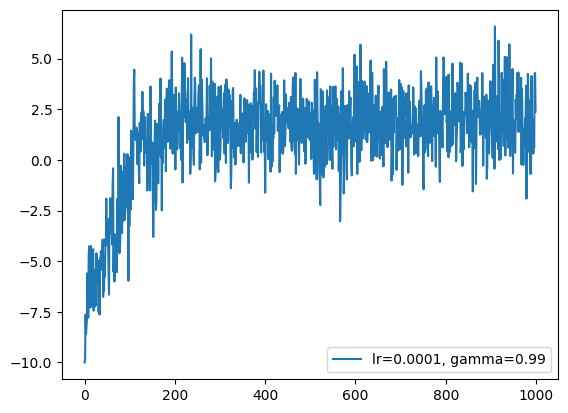

In [20]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()


In [21]:
env = make_env(game_setup_path)

In [22]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, trajectory_policy='boltzmann', label="boltzmann")
    results[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.ndarray'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/home/jedld/.local/lib/python3.10/site-packages/

0: avg rewards -6.294444444444444 std: 5.605431669151883 best avg -10@0 temperature 5.0
Buffer size: 8
Memory usage: 135616 bytes
best: -6.294444444444444
10: avg rewards -4.677777777777778 std: 7.018463304776469 best avg -6.294444444444444@0 temperature 4.950224401048741
Buffer size: 88
Memory usage: 1055680 bytes
best: -4.677777777777778
20: avg rewards -3.0944444444444446 std: 6.33217825724146 best avg -4.677777777777778@10 temperature 4.900944324147673
Buffer size: 168
Memory usage: 2312832 bytes
best: -3.0944444444444446
30: avg rewards 1.4722222222222223 std: 6.650095144589946 best avg -3.0944444444444446@20 temperature 4.852154836315428
Buffer size: 248
Memory usage: 3396992 bytes
best: 1.4722222222222223
40: avg rewards -4.016666666666667 std: 6.75918670686582 best avg 1.4722222222222223@30 temperature 4.803851053679058
Buffer size: 328
Memory usage: 4601152 bytes
50: avg rewards -2.1 std: 8.514359693344787 best avg 1.4722222222222223@30 temperature 4.756028140985157
Buffer siz

In [23]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.001 gamma: 0.99 rewards: [-6.294444444444444, -4.677777777777778, -3.0944444444444446, 1.4722222222222223, -4.016666666666667, -2.1, -2.6444444444444444, -2.5666666666666664, -5.105555555555556, -6.294444444444444, -3.3666666666666667, -4.683333333333334, -5.1611111111111105, -1.5388888888888892, -1.1166666666666665, -2.85, -3.666666666666667, 0.8222222222222219, -4.194444444444444, -1.222222222222222, -1.6833333333333331, -4.022222222222222, -4.9944444444444445, -2.811111111111111, -3.9555555555555553, -3.6944444444444446, -4.611111111111111, -3.3055555555555554, -4.711111111111111, -0.9888888888888888, -0.8944444444444443, -2.761111111111111, -4.427777777777778, -2.8222222222222224, -4.322222222222222, -1.2833333333333332, -1.7777777777777775, -1.116666666666667, -1.6055555555555556, -3.6777777777777776, -0.8611111111111108, -3.5499999999999994, 0.6388888888888888, -2.0555555555555554, -4.322222222222222, -5.211111111111111, -1.3, -0.17777777777777787, -1.1999999999999995, 2.82

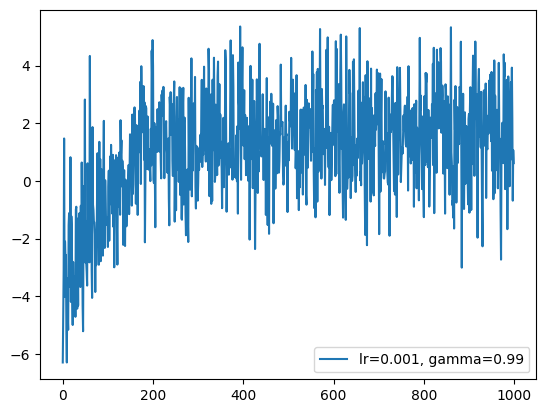

In [24]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Perform some tests on the trained agent. Show a combat log from a fight against the rules based AI. Define a policy based on the Model.

In [25]:
import os

MAX_STEPS = 500
NUM_EPISODES = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModelPolicy:
    def __init__(self, weights_file = 'model_best_boltzmann.pt'):
        self.model = QNetwork(device=device)
        self.model.to(device)
        if not os.path.exists(weights_file):
            raise FileNotFoundError(f"Model file {weights_file} not found. Please run dnd_dqn.ipynb notebook to train an agent.")
        self.model.load_state_dict(torch.load(weights_file))

    def action(self, state, info):
        available_moves = info["available_moves"]
        values = torch.stack([self.model(state, move) for move in available_moves])
        for index, v in enumerate(values):
            print(f"{index}: {available_moves[index]} {v.item()}")

        chosen_index = torch.argmax(values).item()
        return available_moves[chosen_index]


In [26]:

env = make_env(game_setup_path)

print("=========================================")
print("Battle between an RL agent vs a Rules based AI")
print("=========================================")
win_count = 0
loss_count = 0
for i in range(NUM_EPISODES):
    observation, info = env.reset()
    model = ModelPolicy()
    action = action = model.action(observation, info)

    print(f"selected action: {action}")
    terminal = False
    episode = 0

    while not terminal and episode < MAX_STEPS:
        episode += 1
        observation, reward, terminal, truncated, info = env.step(action)
        print(env.render())
        if not terminal and not truncated:
            episode_name_with_padding = str(episode).zfill(3)

            # display entity healths
            print(f"Turn {info['current_index']}\n")
            print(f"Reward: {reward}\n")
            print(f"health hero: {observation['health_pct']}\n")
            print(f"health enemy: {observation['health_enemy']}\n")
            print(env.render())
            
            action = model.action(observation, info)
            print(f"agent selected action: {action}")

        if terminal or truncated:
            print(f"Reward: {reward}")
            if reward > 0:
                win_count += 1
            else:
                loss_count += 1
            break
        
print(f"Win count: {win_count} Loss count: {loss_count} Win rate: {win_count/(win_count+loss_count)}")

Battle between an RL agent vs a Rules based AI
0: (0, (0, 0), (-1, 0), 2, 0) -6.6862969398498535
1: (0, (0, 0), (-1, 0), 2, 1) -6.802910327911377
2: (0, (0, 0), (-1, 0), 20, 0) -8.05439281463623
3: (4, (-1, -1), (0, 0), 0, 0) -7.821082592010498
4: (2, (-1, -1), (0, 0), 0, 0) -7.945087909698486
5: (3, (-1, -1), (0, 0), 0, 0) -7.627752780914307
6: (1, (-1, -1), (0, 0), 0, 0) -7.340939044952393
7: (1, (-1, 1), (0, 0), 0, 0) -7.514814853668213
8: (1, (0, -1), (0, 0), 0, 0) -7.5050482749938965
9: (1, (0, 1), (0, 0), 0, 0) -7.678922176361084
10: (1, (1, -1), (0, 0), 0, 0) -7.669156551361084
11: (1, (1, 1), (0, 0), 0, 0) -7.895975589752197
12: (10, (-1, -1), (0, 0), 0, 0) -7.462772846221924
13: (12, (-1, -1), (0, 0), 101, 0) -7.921004772186279
14: (12, (-1, -1), (0, 0), 104, 0) -7.458012104034424
15: (12, (-1, -1), (0, 0), 107, 0) -7.534063816070557
16: (12, (-1, -1), (0, 0), 105, 1) -7.67972993850708
17: (12, (-1, -1), (0, 0), 106, 1) -4.582642078399658
18: (-1, (0, 0), (0, 0), 0, 0) -7.5403

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


0: (1, (-1, 0), (0, 0), 0, 0) -2.7259814739227295
1: (1, (-1, 1), (0, 0), 0, 0) -2.8332362174987793
2: (1, (0, -1), (0, 0), 0, 0) -2.382650852203369
3: (1, (0, 1), (0, 0), 0, 0) -2.5961852073669434
4: (1, (1, -1), (0, 0), 0, 0) -2.1460864543914795
5: (1, (1, 1), (0, 0), 0, 0) -2.359621047973633
6: (6, (-1, -1), (0, 0), 0, 0) -2.0088980197906494
7: (-1, (0, 0), (0, 0), 0, 0) -1.987379789352417
agent selected action: (-1, (0, 0), (0, 0), 0, 0)
____________
____________
____________
____________
____________
_____.......
_____.P.....
_____..E#  .
_____.~~~   
_____~~~... 
_____~~.....
____________
Reward: -0.41666666666666663
0: (0, (0, 0), (1, -1), 14, 0) -7.193012237548828
1: (0, (0, 0), (1, -1), 12, 1) -7.489058971405029
2: (0, (0, 0), (1, -1), 20, 0) -8.367048263549805
3: (4, (-1, -1), (0, 0), 0, 0) -7.324316501617432
4: (2, (-1, -1), (0, 0), 0, 0) -8.261693954467773
5: (3, (-1, -1), (0, 0), 0, 0) -7.470489025115967
6: (1, (0, -1), (0, 0), 0, 0) -6.025106430053711
7: (1, (0, 1), (0, 0